# オプショントレーダーによるJ-Quants API活用方法

- マケデコハッカソン LT大会 presented by J-Quants
- driller[@patraqushe](https://twitter.com/patraqushe)
- 分析用のソースコードなどは [GitHubリポジトリ](https://github.com/drillan/mkdeco-hackathon-lt) で公開

### お前誰よ

- どりらん
- 日経225オプションをやってます
- fin-py（Python x 金融のコミュニティ）
- かいた本
<table>
    <tr><td><img src="https://image.gihyo.co.jp/assets/images/cover/2020/9784297115685.jpg" width="200"></td>
        <td><img src="https://www.asakura.co.jp/user_data/product_image/12258/1.jpg" width="200"></td>
    </tr>
</table>

- [改訂版 Pythonユーザのための Jupyter［実践］入門](https://amzn.to/3OYmuld)
- [Python インタラクティブ・データビジュアライゼーション入門](https://amzn.to/3oTN3xb)

### 今回はなすこと

- 普段オプショントレーダーがどのようにデータをみているか
    - **J-Quants APIから得られるデータだけ** を使って紹介
- オプションの優位性
    - データだけでも宝の山
- オプションのデータは大変
    - 計算すること、前処理すること、分析するために加工することがたくさんある
    - ある程度の経験がないと難しいが、J-Quants APIのデータをいい感じに前処理するライブラリを作ったので紹介
- オプションデータを使ったトレード戦略
    - 特にここ最近は非常に珍しい状態になっているので、この状況を活かした戦略を立てる

### 今回はなさないこと

- グリークスとか小難しいはなし
    - デルタ、ガンマ、ベガ、ボルガ、バンナ...

## Q1: どちらを持って指したいですか？

![shogi](./images/shogi.png)

- 先手☗ ロング（ショート）
- 後手☖ オプション

### オプション

言葉の意味

- 選択
- 取捨
- 選択肢


### オプション取引は無限の選択肢がある

ごくごく一部の例

- ブル目線でありつつも急落に備える
- 急落した後のリバンドを狙うが、さらに急落した場合にも備える
- ボラティリティの裁定取引
    - ストライク
    - 異限月
- 現物（原資産）のヘッジ

### オプションのデータは宝の山

- ボラティリティのデータを俯瞰することで、さまざまなことが読み取れる
- 相場参加者の恐怖・楽観・不安...
- **みんなが見ていないデータこそ価値がある**

![](./images/dq.jpg)

### オプションのデータって...

- とにかくデータが多い
- とにかく計算しないといけない
- とにかく前処理しないといけない

### こんなこともあろうかと

- ライブラリ（Pythonパッケージ）を作った
- 前処理不要
- 一発で可視化
- ほかにもあると便利な機能

## jquants-derivatives

-  [J-Quants API Python クライアントライブラリ (jquants-api-client)](https://github.com/J-Quants/jquants-api-client-python) のデリバティブ用ラッパー
- J-Quants APIのスタンダード以上のプランが必要
- GitHub: https://github.com/drillan/jquants-derivatives
- PyPI: https://pypi.org/project/jquants-derivatives/

### インストール

pipでインストール

```bash
pip install jquants-derivatives
```

### データの取得

`jquantsapi.Client` クラスを継承しているので、[jquants-api-client](https://github.com/J-Quants/jquants-api-client-python)同じように使える

In [1]:
import jquants_derivatives

cli = jquants_derivatives.Client()

In [2]:
%%time
df_20230605 = cli.get_option_index_option("2023-06-05")
df_20230605.iloc[:3, :6]

CPU times: user 130 ms, sys: 17.3 ms, total: 147 ms
Wall time: 8.35 s


,Date,Code,WholeDayOpen,WholeDayHigh,WholeDayLow,WholeDayClose
0,2023-06-05,130060018,0.0,0.0,0.0,0.0
1,2023-06-05,130060218,0.0,0.0,0.0,0.0
2,2023-06-05,130060518,0.0,0.0,0.0,0.0


### キャッシュ機能

- リクエストしたデータはディスクに保存される
    - sqlite3のデータベース
- 2回目以降はディスクから読み込まれる
    - 高速な処理
    - サーバに負荷をかけない ←**重要！**

In [3]:
%%time
df_20230605 = cli.get_option_index_option("2023-06-05")

CPU times: user 40.3 ms, sys: 167 µs, total: 40.5 ms
Wall time: 39.4 ms


### キャッシュされたらデータからSQLでクエリできる

```bash
pip install ipython-sql
```

In [4]:
%load_ext sql

In [5]:
%sql sqlite:////home/vscode/.jquants-api/jquantsapi.db

#### テーブルの一覧

In [6]:
%sql SELECT name FROM sqlite_master WHERE type='table';

 * sqlite:////home/vscode/.jquants-api/jquantsapi.db
Done.


name
FINS_ANNOUNCEMENT
FINS_DIVIDEND
FINS_STATEMENTS
INDICES_TOPIX
LISTED_INFO
MARKETS_BREAKDOWN
MARKET_SEGMENT
MARKET_SHORT_SELLING
OPTION_INDEX_OPTION
PRICES_DAILY_QUOTES


#### SELECT文によるクエリ

In [7]:
%sql SELECT Date, UnderlyingPrice, StrikePrice FROM OPTION_INDEX_OPTION LIMIT 3;

 * sqlite:////home/vscode/.jquants-api/jquantsapi.db
Done.


Date,UnderlyingPrice,StrikePrice
2023-06-05 00:00:00,32217.43,20000.0
2023-06-05 00:00:00,32217.43,20250.0
2023-06-05 00:00:00,32217.43,20500.0


#### pandasによるクエリ

In [8]:
import sqlite3
import pandas as pd

with sqlite3.connect(jquants_derivatives.database.db) as con:
    query_df = pd.read_sql("SELECT Date, UnderlyingPrice, StrikePrice FROM OPTION_INDEX_OPTION", con)

query_df.head()

,Date,UnderlyingPrice,StrikePrice
0,2023-06-05 00:00:00,32217.43,20000.0
1,2023-06-05 00:00:00,32217.43,20250.0
2,2023-06-05 00:00:00,32217.43,20500.0
3,2023-06-05 00:00:00,32217.43,20750.0
4,2023-06-05 00:00:00,32217.43,21000.0


### 型変換機能

DataFrameの各列は[jquants_derivatives/models](https://github.com/drillan/jquants-derivatives/blob/main/jquants_derivatives/models.py)で定義したデータ型に自動で型変換される

```python
@dataclass
class IndexOption(DataFrameColumnsBase):
    Date: np.dtype("datetime64[ns]")
    Code: str
    WholeDayOpen: float
    WholeDayHigh: float
    WholeDayLow: float
    WholeDayClose: float
    ...
    LastTradingDay: np.dtype("datetime64[ns]")
    SpecialQuotationDay: np.dtype("datetime64[ns]")
    SettlementPrice: float
    TheoreticalPrice: float
    BaseVolatility: float
    UnderlyingPrice: float
    ImpliedVolatility: float
    InterestRate: float

    @classmethod
    def get_dtype(cls, field: str) -> Type[Any]:
        key = field.replace("(", "").replace(")", "")
        return cls.__annotations__[key]
```

### 型変換とキャッシュ機能はjquants-api-clientにPRするかも？

- もしこれらの機能を気に入ってくれるなら、本家に取り込んでもらいたい
- 現状は `オプション四本値(/option/index_option)` のエンドポイントにしか対応していない

### Optionクラス

- 実務上扱いやすい形式に変換するクラス

In [9]:
from jquants_derivatives import Option

op_20230605 = Option(df_20230605, contracts=2)
op_20230605.contract_month

['2023-06', '2023-07']

In [10]:
op_20230605.underlying_price

{'2023-06': 32217.43, '2023-07': 32217.43}

In [11]:
op_20230605.contracts_dfs["2023-06"].head()

,Date,Code,WholeDayOpen,WholeDayHigh,WholeDayLow,WholeDayClose,NightSessionOpen,NightSessionHigh,NightSessionLow,NightSessionClose,...,EmergencyMarginTriggerDivision,PutCallDivision,LastTradingDay,SpecialQuotationDay,SettlementPrice,TheoreticalPrice,BaseVolatility,UnderlyingPrice,ImpliedVolatility,InterestRate
0,2023-06-05,138067618,3.0,3.0,1.0,1.0,3.0,3.0,3.0,3.0,...,002,1,2023-06-08,2023-06-09,1.0,1.0000,0.195121,32217.43,0.513807,-0.000664
1,2023-06-05,188067718,3.0,4.0,1.0,2.0,3.0,4.0,3.0,3.0,...,002,1,2023-06-08,2023-06-09,2.0,2.0000,0.195121,32217.43,0.535335,-0.000664
2,2023-06-05,138067818,3.0,4.0,2.0,2.0,3.0,4.0,3.0,3.0,...,002,1,2023-06-08,2023-06-09,2.0,2.0844,0.195121,32217.43,0.520748,-0.000664
3,2023-06-05,188068018,3.0,4.0,1.0,2.0,3.0,4.0,3.0,3.0,...,002,1,2023-06-08,2023-06-09,2.0,2.0000,0.195121,32217.43,0.506194,-0.000664
4,2023-06-05,138068118,4.0,4.0,2.0,2.0,4.0,4.0,3.0,3.0,...,002,1,2023-06-08,2023-06-09,2.0,2.0000,0.195121,32217.43,0.491672,-0.000664


### ボラティリティの可視化

Plotlyによる可視化

In [12]:
# スライド表示用なので、実際にノートブックで実行するときはスキップしてください
import plotly.io as pio

pio.renderers.default = "png"

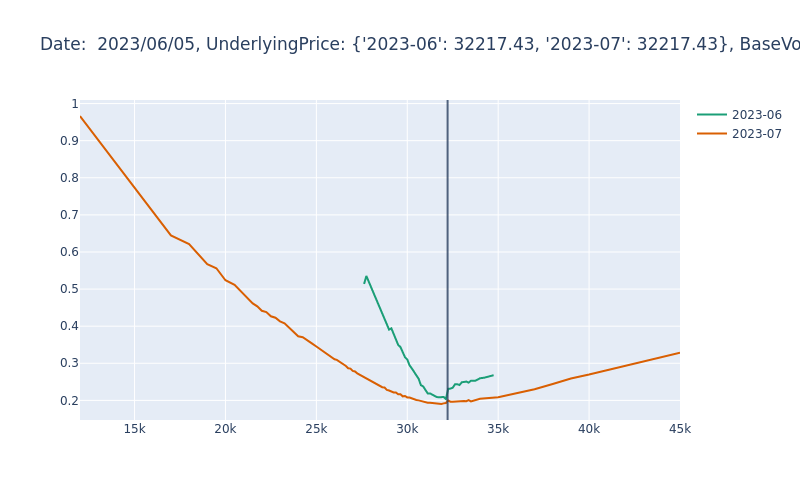

In [13]:
jquants_derivatives.plot_volatility(op_20230605).update_layout(width=800)

#### 異なる日のデータを比較

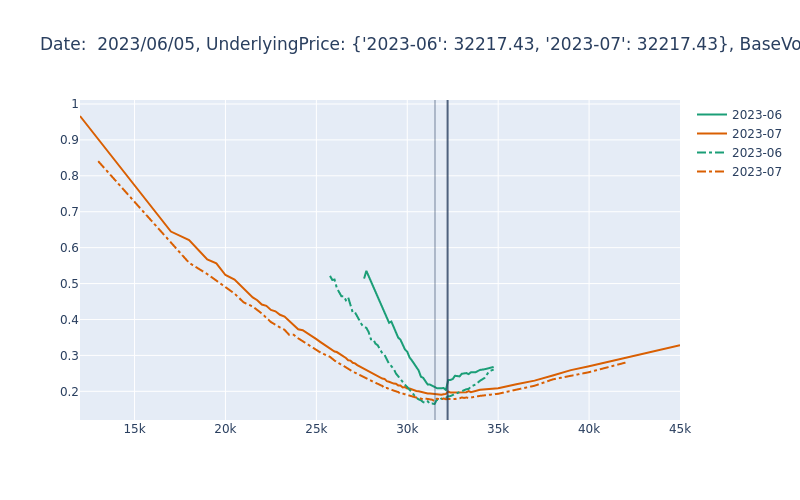

In [14]:
df_20230602 = cli.get_option_index_option("2023-06-02")
op_20230602 = Option(df_20230602)
jquants_derivatives.plot_volatility(op_20230605, op_20230602).update_layout(width=800)

In [15]:
import pickle

with open("save_fig.pickle", "rb") as f:
    save_fig = pickle.load(f)

## インプライドボラティリティと原資産価格を分析

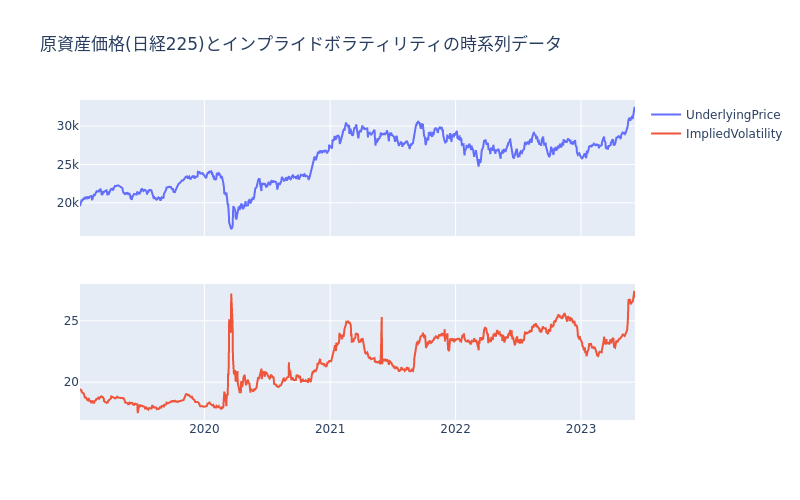

In [16]:
save_fig["原資産価格(日経225)とインプライドボラティリティの時系列データ"]

### 原資産価格とボラティリティの騰落率

- 原資産価格が上昇→ボラティリティが下落（上げ剥げ:アゲハゲ）
- 原資産価格が下落→ボラティリティが上昇（下げ盛り:サゲモリ)

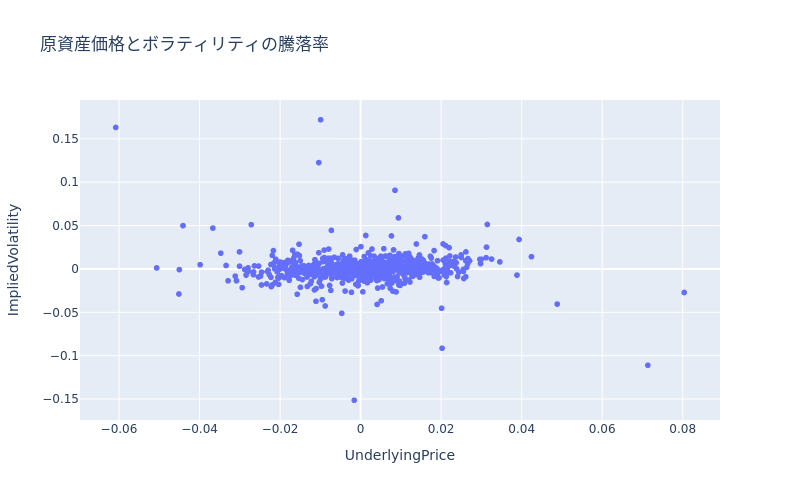

In [17]:
save_fig["原資産価格とボラティリティの騰落率"]

### ボラティリティの上昇局面・下落局面においての原資産価格の分布

- ボラティリティが上昇すると、ダウンサイドのテール
- ボラティリティが下落すると、アップサイドのテール

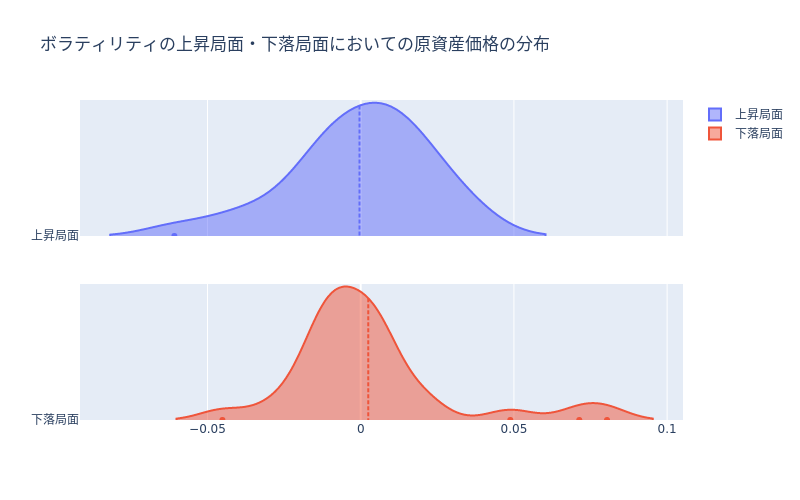

In [18]:
save_fig["ボラティリティの上昇局面・下落局面においての原資産価格の分布"]

### 2023年5月は特殊な状況に

- 2019年以降、1076日中、上げ盛り（アゲモリ）は39日
- 直近では極めてめずらしいアゲモリ状態に

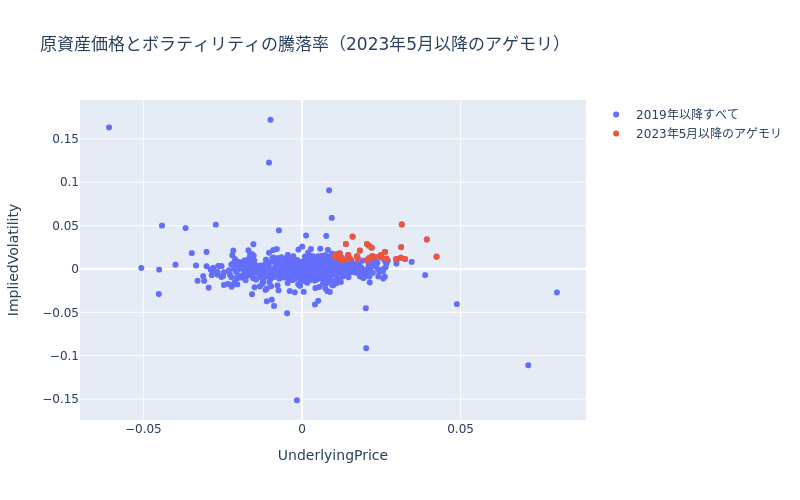

In [19]:
save_fig["原資産価格とボラティリティの騰落率（2023年5月以降のアゲモリ）"]

### アゲモリ局面の原資産価格の分布

- 原資産価格とボラティリティの両方が1%以上上昇した場合、しばらくは原資産価格が上昇傾向にある

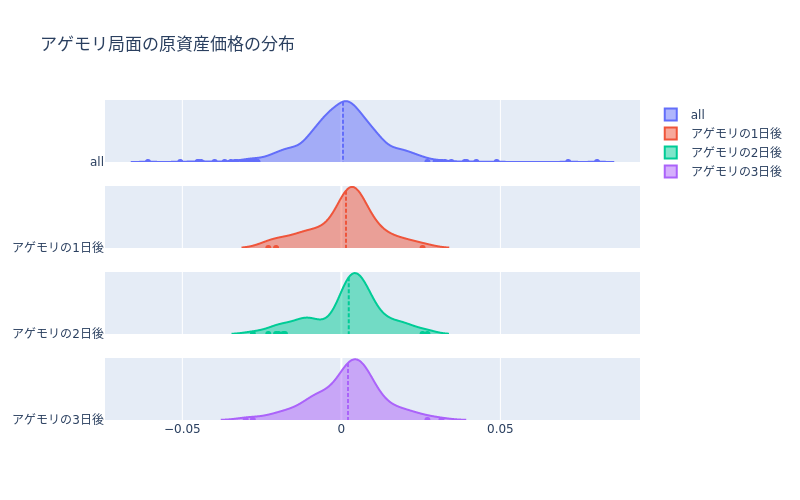

In [20]:
save_fig["アゲモリ局面の原資産価格の分布"]

### アゲモリ局面の原資産価格とボラティリティの分布

- 原資産価格価格の上昇が続いても、ボラティリティは落ち着いていく

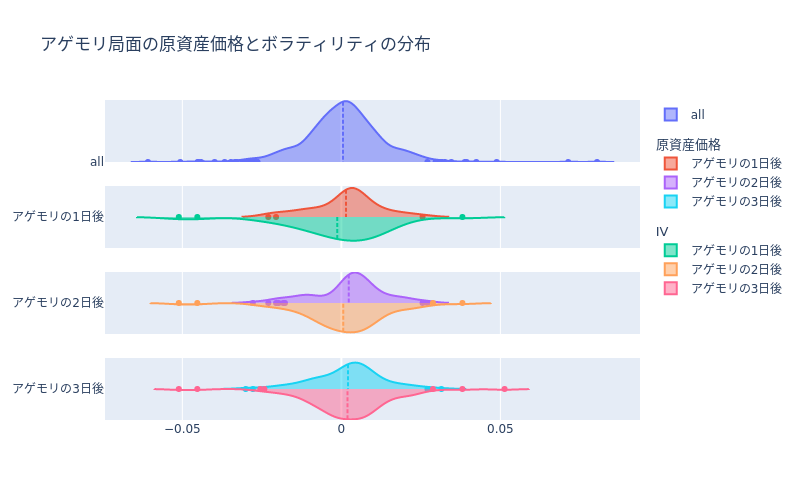

In [21]:
save_fig["アゲモリ局面の原資産価格とボラティリティの分布"]

## アゲモリ局面のトレード戦略

- 原資産（先物）をロング
- ボラティリティ(オプション）をショート
    - ボラティリティだけをショートする方法はないので、実際にはVI先物やオプションを使う

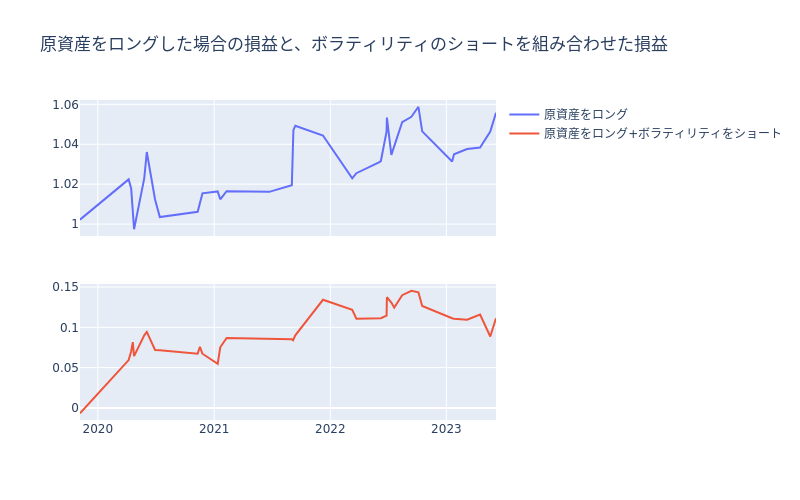

In [22]:
save_fig["原資産をロングした場合の損益と、ボラティリティのショートを組み合わせた損益"]

### 2019年11月5日のボラティリティスマイル

- 無作為にアゲモリの最初のデータを抽出
- 特にコール側のボラティリティが盛っている

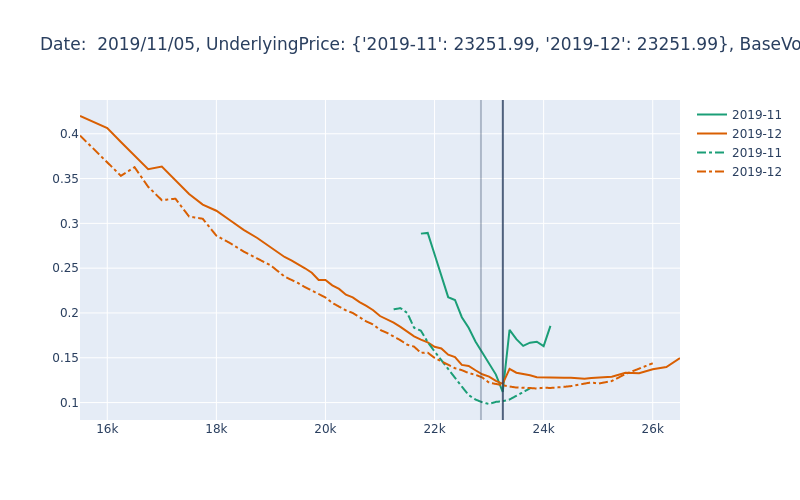

In [23]:
save_fig["2019年11月5日のボラティリティスマイル"]

### トレード戦略（カバードコール）

- 原資産（先物12月限）をロング
    - @23251.99
- コールオプション（12月限23500）をショート
    - @290

### 2019年11月6日のボラティリティスマイル

- コール側のボラティリティが下落（アゲハゲ）

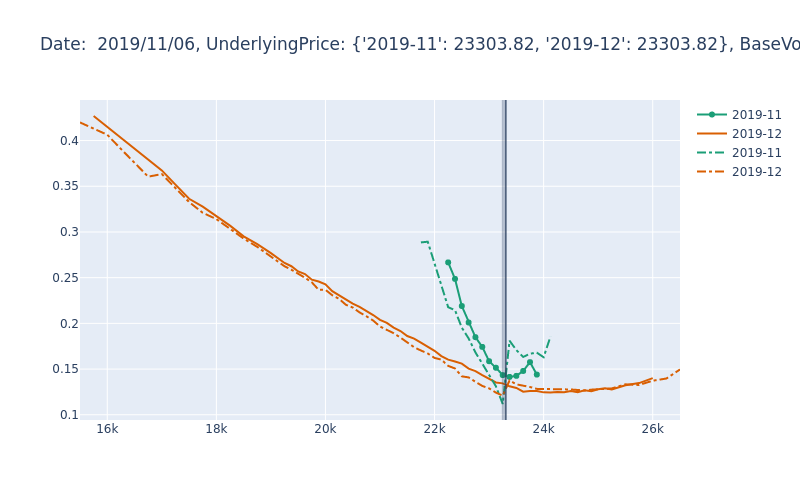

In [24]:
save_fig["2019年11月6日のボラティリティスマイル"]

### トレード損益

- 原資産（先物12月限）をロング
    - @23251.99 -> 23303.82 = 51.83
- コールオプション（12月限23500）をショート
    - @290 -> 295 = -5
- 損益: 46.8 = 1セット当たり: 46,800円
- たんに先物をロングしたほうが儲かる？
    - 仮に先物が下がっても満期までの下落が290円までなら、損益がプラスになる

### どうやって分析したり可視化するコードを書くの？

今回の内容はこの本を読めば書けるようになるはず

<table>
    <tr><td><img src="https://image.gihyo.co.jp/assets/images/cover/2020/9784297115685.jpg" width="200"></td>
        <td><img src="https://www.asakura.co.jp/user_data/product_image/12258/1.jpg" width="200"></td>
    </tr>
</table>

## まとめ

- J-Quants APIから得られるデータだけでも、有効に使える
    - 今回は時間が限らているので、活用方法のごく一例だけを紹介
- データを活用するにはツールが必要 ← 作ったので使ってね
- オプションを活用することでトレードの幅が広がる